# Use TRPO to Play Acrobot-v1

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers


imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

11:56:31 [INFO] env: <AcrobotEnv<Acrobot-v1>>
11:56:31 [INFO] action_space: Discrete(3)
11:56:31 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
11:56:31 [INFO] reward_range: (-inf, inf)
11:56:31 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
11:56:31 [INFO] _max_episode_steps: 500
11:56:31 [INFO] _elapsed_steps: None


In [3]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)
    
    def store(self, df):
        self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)
        
    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
def conjugate_gradient(f, b, iter_count=10, epsilon=1e-12, tol=1e-6):
    x = b * 0.
    r = tf.identity(b)
    p = tf.identity(b)
    rho = tf.reduce_sum(r * r)
    for i in range(iter_count):
        z = f(p)
        alpha = rho / (tf.reduce_sum(p * z) + epsilon)
        x += alpha * p
        r -= alpha * z
        rho_new = tf.reduce_sum(r * r)
        p = r + (rho_new / rho) * p
        rho = rho_new
        if rho < tol:
            break
    return x, f(x)

In [5]:
class TRPOAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        
        self.replayer = PPOReplayer()
        self.trajectory = []

        self.max_kl = 0.01
        self.actor_net = self.build_net(hidden_sizes=[100,],
                output_size=self.action_n, output_activation=nn.softmax)
        self.critic_net = self.build_net(hidden_sizes=[100,],
                learning_rate=0.002)

    def build_net(self, input_size=None, hidden_sizes=None, output_size=1, 
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(layers.Dense(units=hidden_size,
                    activation=activation))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5): # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer() # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'done', 'action'], dtype=object)
        states = np.stack(df['state'])
        df['v'] = self.critic_net.predict(states)
        pis = self.actor_net.predict(states)
        df['prob'] = [pi[action] for pi, action in zip(pis, df['action'])]
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        action_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
        old_pi_tensor = tf.convert_to_tensor(old_pis, dtype=tf.float32)
        advantage_tensor = tf.convert_to_tensor(advantages, dtype=tf.float32)
        
        # train actor
        # ... calculate first order gradient of KL divergence
        with tf.GradientTape() as tape:
            all_pi_tensor = self.actor_net(state_tensor)
            pi_tensor = tf.gather(all_pi_tensor, action_tensor, batch_dims=1)
            surrogate_tensor = (pi_tensor / old_pi_tensor) * advantage_tensor
        actor_grads = tape.gradient(surrogate_tensor, self.actor_net.variables)
        loss_grad = tf.concat([tf.reshape(grad, (-1,)) for grad in actor_grads], axis=0)
        
        # ... calculate conjugate gradient: Fx = g
        def f(x): # calculate Fx
            with tf.GradientTape() as tape2: # tape for 2nd-order gradient
                with tf.GradientTape() as tape1: # tape for 1st-order gradient
                    prob_tensor = self.actor_net(state_tensor)
                    prob_old_tensor = tf.stop_gradient(prob_tensor)
                    kld_tensor = tf.reduce_sum(prob_old_tensor * (tf.math.log(
                            prob_old_tensor) - tf.math.log(prob_tensor)), axis=1)
                    kld_loss_tensor = tf.reduce_mean(kld_tensor)
                grads = tape1.gradient(kld_loss_tensor, self.actor_net.variables)
                flatten_grad_tensor = tf.concat(
                        [tf.reshape(grad, (-1,)) for grad in grads], axis=-1)
                grad_matmul_x = tf.tensordot(flatten_grad_tensor, x, axes=[[-1], [-1]])
            grad_grads = tape2.gradient(grad_matmul_x, self.actor_net.variables)
            flatten_grad_grad = tf.stop_gradient(tf.concat(
                    [tf.reshape(grad_grad, (-1,)) for grad_grad in grad_grads], axis=-1))
            fx = flatten_grad_grad + x * 1e-2
            return fx
        x, fx = conjugate_gradient(f, loss_grad)

        # ... calculate natural gradient
        natural_gradient_tensor = tf.sqrt(2 * self.max_kl / tf.reduce_sum(fx * x)) * x
        # ....... refactor the flatten gradient into un-flatten version
        flatten_natural_gradient = natural_gradient_tensor.numpy()
        natural_grads = []
        begin = 0
        for weight in self.actor_net.get_weights():
            end = begin + weight.size
            natural_grad = flatten_natural_gradient[begin:end].reshape(weight.shape)
            natural_grads.append(natural_grad)
            begin = end
        
        # ... line search
        old_weights = self.actor_net.get_weights()
        expected_improve = tf.reduce_sum(loss_grad * natural_gradient_tensor).numpy()
        for learning_step in [0.,] + [.5 ** j for j in range(10)]:
            self.actor_net.set_weights([weight + learning_step * grad
                    for weight, grad in zip(old_weights, natural_grads)])
            all_pi_tensor = self.actor_net(state_tensor)
            new_pi_tensor = tf.gather(all_pi_tensor, action_tensor[:, np.newaxis], axis=1)[:, 0]
            new_pi_tensor = tf.stop_gradient(new_pi_tensor)
            surrogate_tensor = (new_pi_tensor / pi_tensor) * advantage_tensor
            objective = tf.reduce_sum(surrogate_tensor).numpy()
            if np.isclose(learning_step, 0.):
                old_objective = objective
            else:
                if objective - old_objective > 0.1 * expected_improve * learning_step:
                    break # success, keep the weight
        else:
            self.actor_net.set_weights(old_weights)

        # train critic
        self.critic_net.fit(states, returns, verbose=0)


agent = TRPOAgent(env)

11:56:32 [INFO] ==== train ====
11:57:06 [INFO] NumExpr defaulting to 8 threads.
11:57:06 [DEBUG] train episode 0: reward = -500.00, steps = 500
11:57:41 [DEBUG] train episode 1: reward = -500.00, steps = 500
11:58:14 [DEBUG] train episode 2: reward = -500.00, steps = 500
11:58:39 [DEBUG] train episode 3: reward = -386.00, steps = 387
11:59:14 [DEBUG] train episode 4: reward = -500.00, steps = 500
11:59:42 [DEBUG] train episode 5: reward = -425.00, steps = 426
12:00:09 [DEBUG] train episode 6: reward = -399.00, steps = 400
12:00:39 [DEBUG] train episode 7: reward = -427.00, steps = 428
12:00:59 [DEBUG] train episode 8: reward = -299.00, steps = 300
12:01:23 [DEBUG] train episode 9: reward = -369.00, steps = 370
12:01:58 [DEBUG] train episode 10: reward = -500.00, steps = 500
12:02:21 [DEBUG] train episode 11: reward = -341.00, steps = 342
12:02:48 [DEBUG] train episode 12: reward = -405.00, steps = 406
12:03:15 [DEBUG] train episode 13: reward = -394.00, steps = 395
12:03:36 [DEBUG] tr

12:31:05 [DEBUG] train episode 125: reward = -213.00, steps = 214
12:31:16 [DEBUG] train episode 126: reward = -167.00, steps = 168
12:31:32 [DEBUG] train episode 127: reward = -212.00, steps = 213
12:31:39 [DEBUG] train episode 128: reward = -115.00, steps = 116
12:31:49 [DEBUG] train episode 129: reward = -145.00, steps = 146
12:32:00 [DEBUG] train episode 130: reward = -161.00, steps = 162
12:32:10 [DEBUG] train episode 131: reward = -153.00, steps = 154
12:32:33 [DEBUG] train episode 132: reward = -343.00, steps = 344
12:32:47 [DEBUG] train episode 133: reward = -185.00, steps = 186
12:33:00 [DEBUG] train episode 134: reward = -194.00, steps = 195
12:33:11 [DEBUG] train episode 135: reward = -160.00, steps = 161
12:33:25 [DEBUG] train episode 136: reward = -223.00, steps = 224
12:33:40 [DEBUG] train episode 137: reward = -211.00, steps = 212
12:33:56 [DEBUG] train episode 138: reward = -237.00, steps = 238
12:34:07 [DEBUG] train episode 139: reward = -163.00, steps = 164
12:34:22 [

12:50:33 [DEBUG] test episode 57: reward = -98.00, steps = 99
12:50:42 [DEBUG] test episode 58: reward = -137.00, steps = 138
12:50:49 [DEBUG] test episode 59: reward = -102.00, steps = 103
12:50:57 [DEBUG] test episode 60: reward = -116.00, steps = 117
12:51:03 [DEBUG] test episode 61: reward = -82.00, steps = 83
12:51:11 [DEBUG] test episode 62: reward = -124.00, steps = 125
12:51:18 [DEBUG] test episode 63: reward = -98.00, steps = 99
12:51:24 [DEBUG] test episode 64: reward = -92.00, steps = 93
12:51:32 [DEBUG] test episode 65: reward = -118.00, steps = 119
12:51:47 [DEBUG] test episode 66: reward = -228.00, steps = 229
12:51:54 [DEBUG] test episode 67: reward = -119.00, steps = 120
12:52:04 [DEBUG] test episode 68: reward = -146.00, steps = 147
12:52:14 [DEBUG] test episode 69: reward = -146.00, steps = 147
12:52:21 [DEBUG] test episode 70: reward = -117.00, steps = 118
12:52:30 [DEBUG] test episode 71: reward = -124.00, steps = 125
12:52:39 [DEBUG] test episode 72: reward = -143.

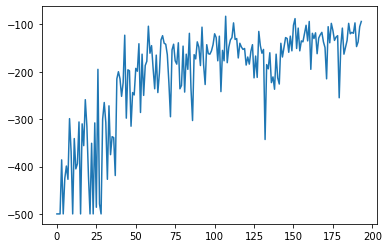

In [6]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [7]:
env.close()